In [1]:
%load_ext autoreload
%autoreload

import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GroupKFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import random

from equationmodel_ann import ann_mlp_regression, prediction_rmse_error, ann_linear_compare_graph, errorDist
from util import ADD_data_loader, combineDF, filteringDF, getFreeSpacePathLoss, makeXforGraphWithGroupingFrequency,\
                makeXforGraph, inverseScale, samplingData, normalizeData,train_2d_graph, train_3d_graph

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

desired_width=620
pd.set_option('display.width', desired_width)
pd.set_option('display.max_columns',30)
pd.options.display.float_format = "{:.2f}".format

In [2]:
%autoreload

wt_fileList = {'../data/PLdata_iksan_wt_400.csv':[('season', 0), ('frequency', 400), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_iksan_wt_1399.csv':[('season', 0), ('frequency', 1399), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_iksan_wt_2249.csv':[('season', 0), ('frequency', 2249), ('heightTB',30), ('heightB',15), ('heightM',2)]}
sp_fileList = {'../data/PLdata_iksan_sp_400.csv':[('season', 0.5), ('frequency', 400), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_iksan_sp_1399.csv':[('season', 0.5), ('frequency', 1399), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_iksan_sp_2249.csv':[('season', 0.5), ('frequency', 2249), ('heightTB',30), ('heightB',15), ('heightM',2)]}
sm_fileList = {'../data/PLdata_iksan_sm_400.csv':[('season', 1.0), ('frequency', 400), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_iksan_sm_1399.csv':[('season', 1.0), ('frequency', 1399), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_iksan_sm_2249.csv':[('season', 1.0), ('frequency', 2249), ('heightTB',30), ('heightB',15), ('heightM',2)]}
addWt = ADD_data_loader(wt_fileList)
print("winter data:",addWt.shape)
print("")
addSp = ADD_data_loader(sp_fileList)
print("spring data:",addSp.shape)
print("")
addSm = ADD_data_loader(sm_fileList)
print("summer data:",addSm.shape)
print("")

# print(addIksan.describe())
# print(addNonsan.describe())
# print(addPaju.describe())

addData = combineDF([addWt, addSp, addSm])
print("antenna_b height filtering-before(data count):",addData.shape)
addData = filteringDF(addData, 'heightTM', [10,100])
print("antenna_b height filtering-after(data count):",addData.shape)

print("freespace pathloss filtering-before(data count):",addData.shape)
addData['freePathloss'] = getFreeSpacePathLoss(addData['distance'],addData['frequency'])
addData = addData[addData['pathloss'] >= addData['freePathloss']]
print("freespace pathloss filtering-after(data count):",addData.shape)

# print("ADD data sample:\n",addData.head())

ADD data preprocessing
../data/PLdata_iksan_wt_2249.csv: distance filtering(before):(108873, 4)
../data/PLdata_iksan_wt_2249.csv: distance filtering(after):(10396, 4)
../data/PLdata_iksan_wt_1399.csv: distance filtering(before):(109060, 4)
../data/PLdata_iksan_wt_1399.csv: distance filtering(after):(10396, 4)
../data/PLdata_iksan_wt_400.csv: distance filtering(before):(109210, 4)
../data/PLdata_iksan_wt_400.csv: distance filtering(after):(10396, 4)
          type  distance  pathloss  heightTM  season  frequency  heightTB  heightB  heightM
type 2713    m      1.00     97.57      0.01       0       2249        30       15        2
     2714    m      1.00    137.38      0.03       0       2249        30       15        2
     2715    m      1.00     99.98      0.01       0       2249        30       15        2
     2716    m      1.00    128.57      0.04       0       2249        30       15        2
     2717    m      1.00    119.13      0.03       0       2249        30       15     

data distribution(before)
       logDistance  logFrequency  logExtendedHeightTratio   season  pathloss
count     65354.00      65354.00                 65354.00 65354.00  65354.00
mean          0.30          3.04                     0.27     0.52    128.55
std           0.13          0.31                     0.15     0.39     20.27
min           0.00          2.60                     0.00     0.00     85.06
25%           0.20          2.60                     0.15     0.00    111.97
50%           0.34          3.15                     0.28     0.50    124.82
75%           0.42          3.35                     0.39     1.00    143.48
max           0.48          3.35                     0.57     1.00    180.80
sampling shape(before):(65354, 5)
sampling shape(after):(19606, 5)
data distribution(after)
       logDistance  logFrequency  logExtendedHeightTratio   season  pathloss
count     19606.00      19606.00                 19606.00 19606.00  19606.00
mean          0.30          3.03   

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2880: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


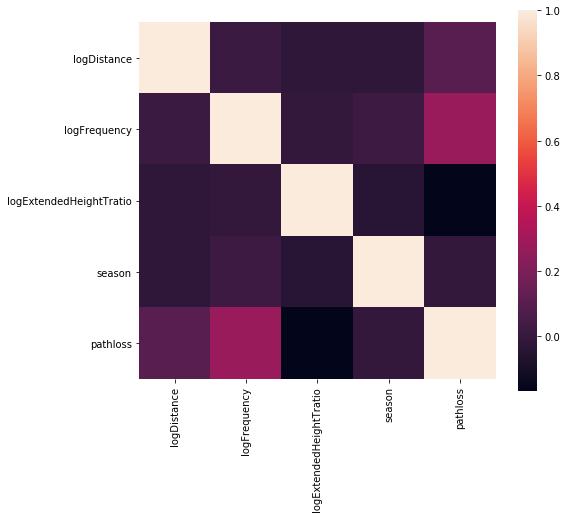

In [3]:
%autoreload

targetCols = ['logDistance', 'logFrequency', 'logExtendedHeightTratio', 'season', 'pathloss']
xCols = ['logDistance', 'logFrequency', 'logExtendedHeightTratio', 'season',]
yCols = 'pathloss'

samplingRatio = 0.3
addDataSampled = samplingData(addData[targetCols], samplingRatio, None)
# addDataSample.sort_values(by=['logDistance'])

sc = 'iksan_4term'
scale = 'manual'

addDataNorm, normalizer = normalizeData(addDataSampled[targetCols], addDataSampled[yCols], scaler = scale)

print("\nADD data description")
print(addDataNorm.describe()['pathloss'])
print("\nCovariance Matrix - ADD data[Target Columns]")
print("Target Columns:", targetCols)
print(addDataNorm.cov()['pathloss'])

print("\nCorrelation Matrix - ADD data[Target Columns]")
print("Target Columns:", targetCols)
corrMat = addDataNorm.corr()
print(corrMat)
f, ax = plt.subplots(figsize=(8,7))
sns.heatmap(corrMat, square=True)

X = np.array(addDataNorm[xCols])
Xorigin = np.array(addData[xCols]) 
Y = np.array(addDataSampled[yCols])

In [4]:
print("ANN-MLP Regression train/test Error")
kf = KFold(n_splits=5, shuffle=True)

bestANNModel = None
bestIdx = 0
modelList = []
dataSet = []
i = 1
prevTestError = 0

for train_index, test_index in kf.split(X):
#     print("TRAIN index:", train_index, "TEST index:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]    
    
    model = ann_mlp_regression((60,), activation='logistic', optimizer='lbfgs')
    model.fit(X_train, y_train.flatten())
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    trainError = np.sqrt(mean_squared_error(y_train, pred_train))
    testError = np.sqrt(mean_squared_error(y_test, pred_test))
    
    print("#"+str(i)+" Error(RMSE)-train:{} / test:{}".format(trainError,testError)) 
    
    dataSet.append([X_train,y_train,X_test,y_test, trainError, testError])
    
    filename = 'model/ann_'+sc+'-'+str(i)+'.sav'
    pickle.dump(model, open(filename, 'wb'))
    
    if i == 1:
        prevTestError = testError
        bestANNModel = model
        bestIdx = i
    if prevTestError > testError:
        bestANNModel = model
        bestIdx = i
        prevTestError = testError
    
    i+=1

ANN-MLP Regression train/test Error
#1 Error(RMSE)-train:13.338884892860868 / test:13.357999370988946
#2 Error(RMSE)-train:14.066588666377145 / test:14.289428277154391
#3 Error(RMSE)-train:13.600547411048622 / test:13.640539223988425
#4 Error(RMSE)-train:14.328334461672348 / test:14.305240815942739
#5 Error(RMSE)-train:13.928641354468594 / test:14.339921805980351


logDistance                 0.30
logFrequency                0.26
logExtendedHeightTratio     0.28
season                      0.51
pathloss                  120.14
dtype: float64
logDistance                 0.30
logFrequency                0.31
logExtendedHeightTratio     0.27
season                      0.52
pathloss                  132.85
dtype: float64
logDistance                 0.31
logFrequency                0.34
logExtendedHeightTratio     0.27
season                      0.53
pathloss                  132.93
dtype: float64


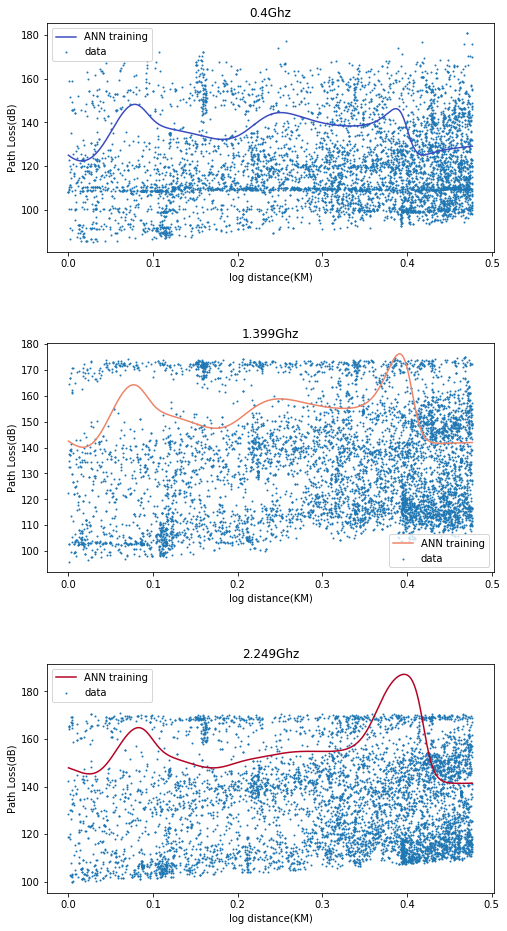

In [5]:
%autoreload
data = makeXforGraphWithGroupingFrequency(pd.DataFrame(X, columns=xCols),
                     pd.DataFrame(Y, columns=['pathloss']), ['logExtendedHeightTratio', 'season'])

graphX = data[0]
graphY = data[1]
train_2d_graph(bestANNModel, None, None,graphX, graphY, 'logDistance', "log distance(KM)")

logDistance                 0.30
logFrequency                0.26
logExtendedHeightTratio     0.28
season                      0.51
pathloss                  120.14
dtype: float64
logDistance                 0.30
logFrequency                0.31
logExtendedHeightTratio     0.27
season                      0.52
pathloss                  132.85
dtype: float64
logDistance                 0.31
logFrequency                0.34
logExtendedHeightTratio     0.27
season                      0.53
pathloss                  132.93
dtype: float64


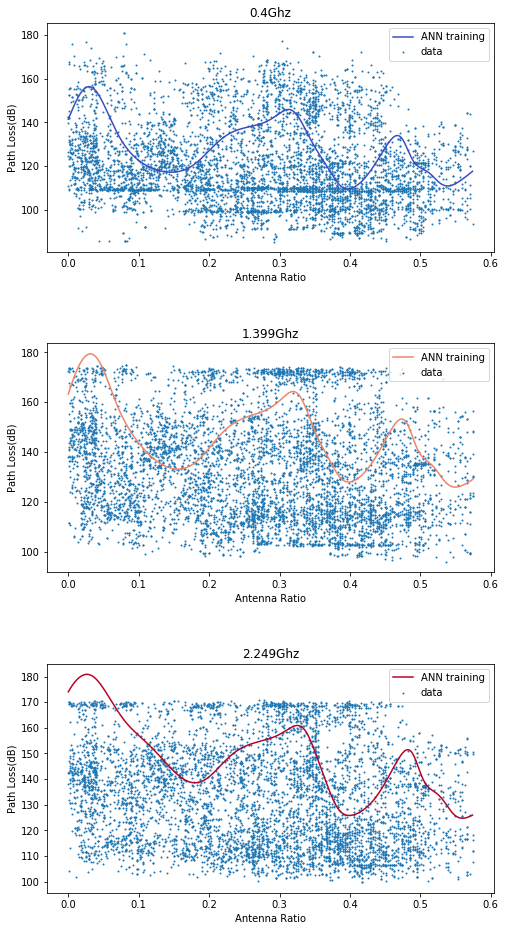

In [6]:
%autoreload
data = makeXforGraphWithGroupingFrequency(pd.DataFrame(X, columns=xCols),
                     pd.DataFrame(Y, columns=['pathloss']), ['logDistance', 'season'])

graphX = data[0]
graphY = data[1]
train_2d_graph(bestANNModel, None, None,graphX, graphY, 'logExtendedHeightTratio', "Antenna Ratio")

logDistance                 0.30
logFrequency                0.26
logExtendedHeightTratio     0.28
season                      0.51
pathloss                  120.14
dtype: float64
logDistance                 0.30
logFrequency                0.31
logExtendedHeightTratio     0.27
season                      0.52
pathloss                  132.85
dtype: float64
logDistance                 0.31
logFrequency                0.34
logExtendedHeightTratio     0.27
season                      0.53
pathloss                  132.93
dtype: float64


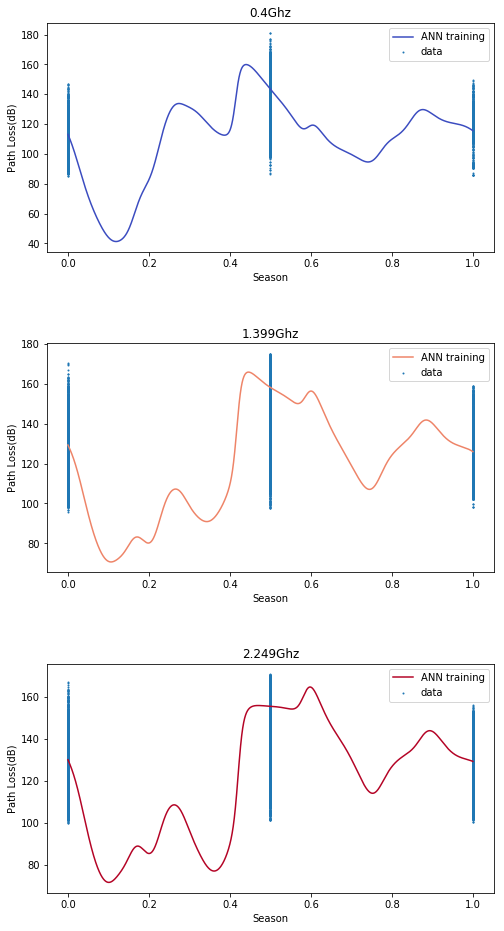

In [7]:
%autoreload
data = makeXforGraphWithGroupingFrequency(pd.DataFrame(X, columns=xCols),
                     pd.DataFrame(Y, columns=['pathloss']), ['logDistance', 'logExtendedHeightTratio'])

graphX = data[0]
graphY = data[1]
train_2d_graph(bestANNModel, None, None,graphX, graphY, 'season', "Season")

3D graph for log distance and log frequency - trainset #1
logDistance                 0.30
logFrequency                0.30
logExtendedHeightTratio     0.27
season                      0.52
pathloss                  128.69
dtype: float64
Index(['logDistance', 'logFrequency', 'logExtendedHeightTratio', 'season'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logExtendedHeightTratio   season
count     10000.00      10000.00                 10000.00 10000.00
mean          0.24          0.30                     0.27     0.52
std           0.14          0.02                     0.00     0.00
min           0.00          0.26                     0.27     0.52
25%           0.12          0.28                     0.27     0.52
50%           0.24          0.30                     0.27     0.52
75%           0.36          0.32                     0.27     0.52
max           0.48          0.34                     0.27     0.52


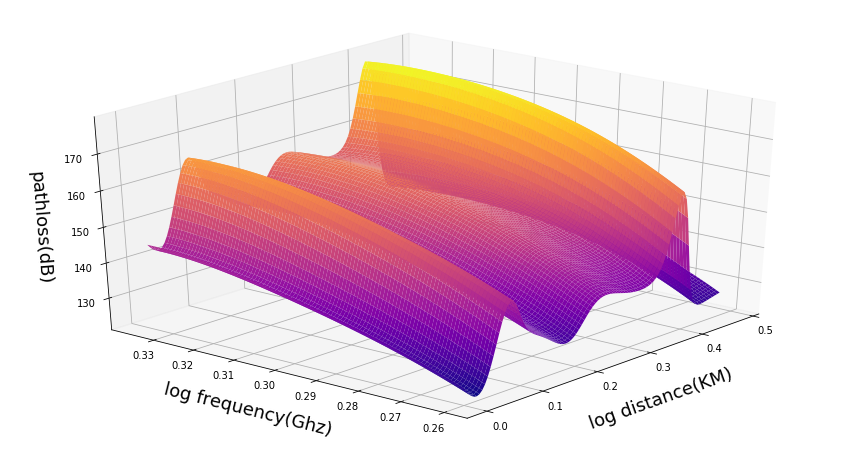

In [8]:
%autoreload
i = 1
print("3D graph for log distance and log frequency - trainset #{}".format(i))
targetCols = ['logDistance', 'logFrequency']
xLabel,yLabel,zLabel = "log distance(KM)","log frequency(Ghz)","pathloss(dB)"
data = makeXforGraph(pd.DataFrame(X, columns=xCols),
                     pd.DataFrame(Y, columns=['pathloss']), targetCols)

graphX = data[0]
graphY = data[1]
train_3d_graph(bestANNModel, graphX, graphY, targetCols, xLabel, yLabel, zLabel)

3D graph for log distance and log antenna height B+TB/M+TM ratio - trainset #1
logDistance                 0.30
logFrequency                0.30
logExtendedHeightTratio     0.27
season                      0.52
pathloss                  128.69
dtype: float64
Index(['logDistance', 'logFrequency', 'logExtendedHeightTratio', 'season'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logExtendedHeightTratio   season
count     10000.00      10000.00                 10000.00 10000.00
mean          0.24          0.30                     0.29     0.52
std           0.14          0.00                     0.17     0.00
min           0.00          0.30                     0.00     0.52
25%           0.12          0.30                     0.14     0.52
50%           0.24          0.30                     0.29     0.52
75%           0.36          0.30                     0.43     0.52
max           0.48          0.30                     0.57     0.52


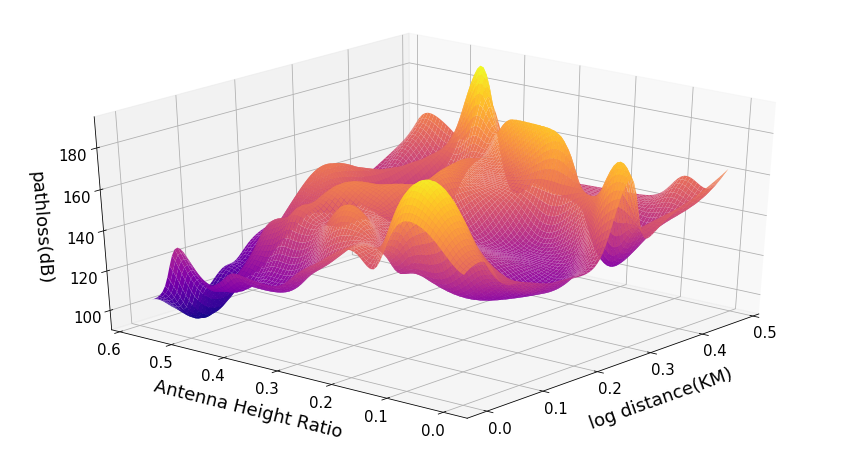

In [9]:
%autoreload
print("3D graph for log distance and log antenna height B+TB/M+TM ratio - trainset #{}".format(i))
xLabel,yLabel,zLabel = "log distance(KM)","Antenna Height Ratio","pathloss(dB)"
varX = ['logDistance', 'logExtendedHeightTratio']
data = makeXforGraph(pd.DataFrame(X, columns=xCols),
                     pd.DataFrame(Y, columns=['pathloss']), varX)

graphX = data[0]
graphY = data[1]
train_3d_graph(bestANNModel, graphX, graphY, varX, xLabel, yLabel, zLabel)

3D graph for log distance and log antenna height B ratio - trainset #1
logDistance                 0.30
logFrequency                0.30
logExtendedHeightTratio     0.27
season                      0.52
pathloss                  128.69
dtype: float64
Index(['logDistance', 'logFrequency', 'logExtendedHeightTratio', 'season'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logExtendedHeightTratio   season
count     10000.00      10000.00                 10000.00 10000.00
mean          0.24          0.30                     0.27     0.50
std           0.14          0.00                     0.00     0.29
min           0.00          0.30                     0.27     0.00
25%           0.12          0.30                     0.27     0.25
50%           0.24          0.30                     0.27     0.50
75%           0.36          0.30                     0.27     0.75
max           0.48          0.30                     0.27     1.00


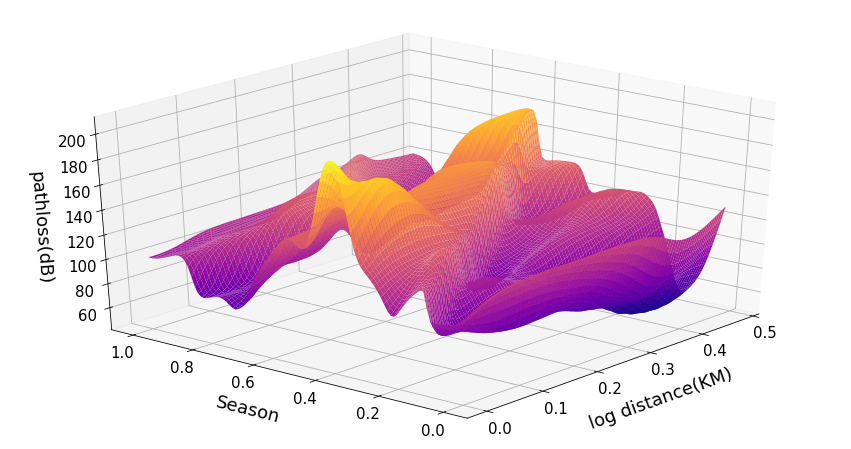

In [10]:
%autoreload
print("3D graph for log distance and log antenna height B ratio - trainset #{}".format(i))
varX = ['logDistance', 'season', ]
xLabel,yLabel,zLabel = "log distance(KM)","Season","pathloss(dB)"
data = makeXforGraph(pd.DataFrame(X, columns=xCols),
                     pd.DataFrame(Y, columns=['pathloss']), varX)

graphX = data[0]
graphY = data[1]
train_3d_graph(bestANNModel, graphX, graphY, varX, xLabel, yLabel, zLabel)

3D graph for log distance and log antenna height B ratio - trainset #1
logDistance                 0.30
logFrequency                0.30
logExtendedHeightTratio     0.27
season                      0.52
pathloss                  128.69
dtype: float64
Index(['logDistance', 'logFrequency', 'logExtendedHeightTratio', 'season'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logExtendedHeightTratio   season
count     10000.00      10000.00                 10000.00 10000.00
mean          0.30          0.30                     0.29     0.50
std           0.00          0.00                     0.17     0.29
min           0.30          0.30                     0.00     0.00
25%           0.30          0.30                     0.14     0.25
50%           0.30          0.30                     0.29     0.50
75%           0.30          0.30                     0.43     0.75
max           0.30          0.30                     0.57     1.00


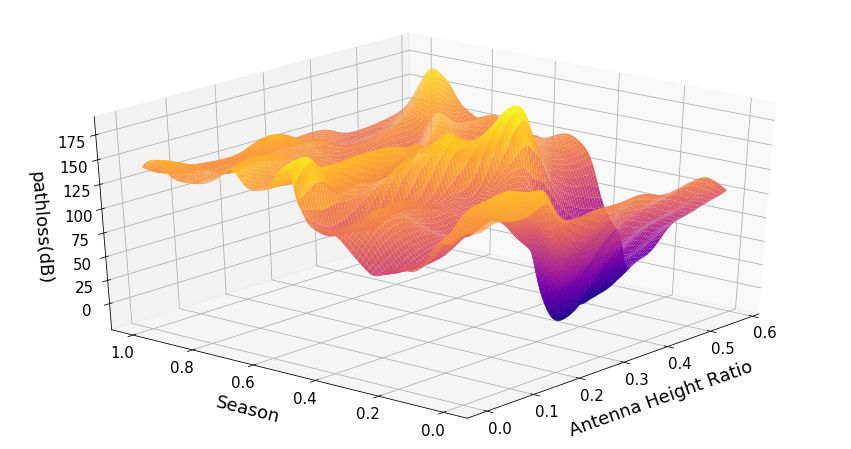

In [11]:
%autoreload
print("3D graph for log distance and log antenna height B ratio - trainset #{}".format(i))
varX = ['logExtendedHeightTratio', 'season']
xLabel,yLabel,zLabel = "Antenna Height Ratio","Season","pathloss(dB)"
data = makeXforGraph(pd.DataFrame(X, columns=xCols),
                     pd.DataFrame(Y, columns=['pathloss']), varX)

graphX = data[0]
graphY = data[1]
train_3d_graph(bestANNModel, graphX, graphY, varX, xLabel, yLabel, zLabel)

3D graph for log distance and log antenna height B ratio - trainset #1
logDistance                 0.30
logFrequency                0.30
logExtendedHeightTratio     0.27
season                      0.52
pathloss                  128.69
dtype: float64
Index(['logDistance', 'logFrequency', 'logExtendedHeightTratio', 'season'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logExtendedHeightTratio   season
count     10000.00      10000.00                 10000.00 10000.00
mean          0.30          0.30                     0.29     0.52
std           0.00          0.02                     0.17     0.00
min           0.30          0.26                     0.00     0.52
25%           0.30          0.28                     0.14     0.52
50%           0.30          0.30                     0.29     0.52
75%           0.30          0.32                     0.43     0.52
max           0.30          0.34                     0.57     0.52


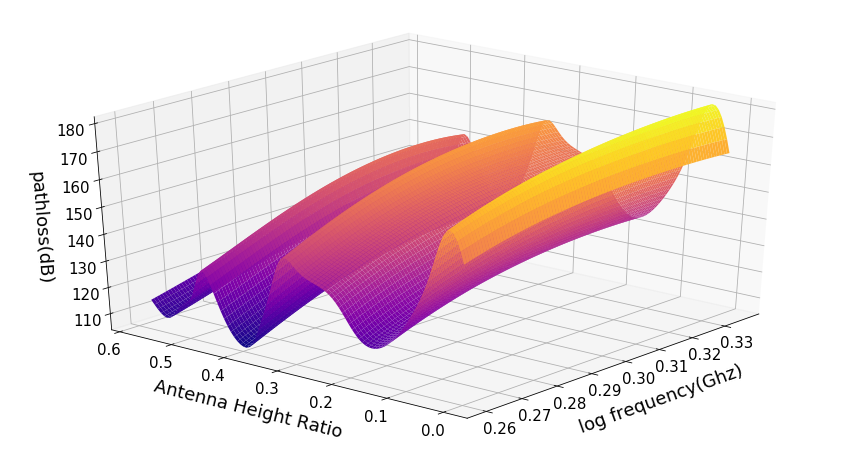

In [12]:
%autoreload
print("3D graph for log distance and log antenna height B ratio - trainset #{}".format(i))
varX = ['logFrequency', 'logExtendedHeightTratio']
xLabel,yLabel,zLabel = "log frequency(Ghz)", "Antenna Height Ratio","pathloss(dB)"
data = makeXforGraph(pd.DataFrame(X, columns=xCols),
                     pd.DataFrame(Y, columns=['pathloss']), varX)

graphX = data[0]
graphY = data[1]
train_3d_graph(bestANNModel, graphX, graphY, varX, xLabel, yLabel, zLabel)

----------------------------------------------------------------------------------------------------
Equation Derivation for trainset #1


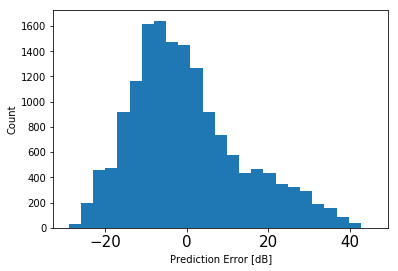

       Error(Noise) Distribution
count                   15684.00
mean                       -0.00
std                        13.72
min                       -28.94
25%                        -9.63
50%                        -2.39
75%                         7.34
max                        45.66
TEST ERROR(dB)    RMSE   MAE  MAPE  RMSLE   R2
ANN Train        13.34 10.30  8.08   0.10 0.57
ANN Test         13.36 10.32  8.12   0.10 0.55
Linear Train     19.14 15.92 12.43   0.15 0.12
Linear Test      18.92 15.76 12.31   0.14 0.10
Diff(ANN,Linear) 13.72 10.84  8.42   0.10 0.21

Objective Function
L_pathloss =  15.93log_d +  18.46log_f + -22.54|log_(hb1/hm1)| +  -0.98s +  74.53
----------------------------------------------------------------------------------------------------
Equation Derivation for trainset #2


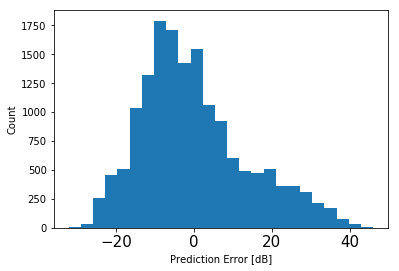

       Error(Noise) Distribution
count                   15685.00
mean                       -0.00
std                        13.76
min                       -32.07
25%                        -9.68
50%                        -2.44
75%                         7.42
max                        45.99
TEST ERROR(dB)    RMSE   MAE  MAPE  RMSLE   R2
ANN Train        13.37 10.33  8.11   0.10 0.57
ANN Test         13.23 10.19  7.99   0.10 0.58
Linear Train     19.10 15.91 12.43   0.14 0.12
Linear Test      19.10 15.83 12.40   0.15 0.12
Diff(ANN,Linear) 13.76 10.90  8.46   0.10 0.21

Objective Function
L_pathloss =  15.06log_d +  18.51log_f + -22.33|log_(hb1/hm1)| +  -0.97s +  74.67
----------------------------------------------------------------------------------------------------
Equation Derivation for trainset #3


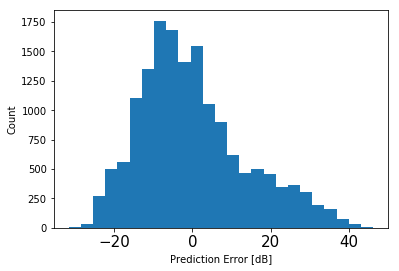

       Error(Noise) Distribution
count                   15685.00
mean                        0.00
std                        13.71
min                       -31.71
25%                        -9.66
50%                        -2.36
75%                         7.37
max                        46.32
TEST ERROR(dB)    RMSE   MAE  MAPE  RMSLE   R2
ANN Train        13.34 10.30  8.09   0.10 0.57
ANN Test         13.34 10.32  8.06   0.10 0.57
Linear Train     19.10 15.90 12.44   0.14 0.12
Linear Test      19.10 15.84 12.28   0.14 0.13
Diff(ANN,Linear) 13.71 10.86  8.43   0.10 0.21

Objective Function
L_pathloss =  15.86log_d +  18.21log_f + -22.42|log_(hb1/hm1)| +  -0.76s +  75.16
----------------------------------------------------------------------------------------------------
Equation Derivation for trainset #4


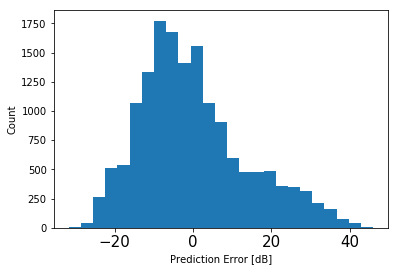

       Error(Noise) Distribution
count                   15685.00
mean                       -0.00
std                        13.74
min                       -31.69
25%                        -9.69
50%                        -2.38
75%                         7.38
max                        46.01
TEST ERROR(dB)    RMSE   MAE  MAPE  RMSLE   R2
ANN Train        13.35 10.30  8.08   0.10 0.57
ANN Test         13.30 10.32  8.10   0.10 0.57
Linear Train     19.12 15.91 12.43   0.15 0.12
Linear Test      19.00 15.79 12.32   0.14 0.12
Diff(ANN,Linear) 13.74 10.87  8.44   0.10 0.21

Objective Function
L_pathloss =  15.44log_d +  18.35log_f + -23.02|log_(hb1/hm1)| +  -0.99s +  75.18
----------------------------------------------------------------------------------------------------
Equation Derivation for trainset #5


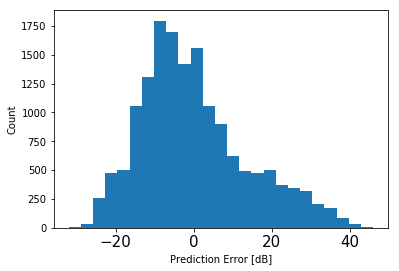

       Error(Noise) Distribution
count                   15685.00
mean                       -0.00
std                        13.76
min                       -31.95
25%                        -9.68
50%                        -2.42
75%                         7.43
max                        45.93
TEST ERROR(dB)    RMSE   MAE  MAPE  RMSLE   R2
ANN Train        13.31 10.29  8.07   0.10 0.57
ANN Test         13.48 10.37  8.15   0.10 0.57
Linear Train     19.03 15.81 12.34   0.14 0.12
Linear Test      19.38 16.24 12.75   0.15 0.11
Diff(ANN,Linear) 13.76 10.90  8.46   0.10 0.21

Objective Function
L_pathloss =  14.92log_d +  18.33log_f + -22.65|log_(hb1/hm1)| +  -0.97s +  75.31


In [13]:
%autoreload

#logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
i = 1
coefSum, interceptSum = np.array([0]*7), 0
bestLinearModel = None
bestIdx = 0
bestStat = None
prevTestError = 0
linearModel = Ridge(alpha=0.0001)

for X_train, y_train, X_test, y_test, trainError, testError in dataSet:
    print("-"*100)
#     X_train = scaler.inverse_transform(X_train)
#     X_test = scaler.inverse_transform(X_test)
    print("Equation Derivation for trainset #{}".format(i))

    ANNPred = bestANNModel.predict(X_train)
    ANNPred_test = bestANNModel.predict(X_test)  
    
    linearModel.fit(X_train, ANNPred)     
    linearPredTrain = linearModel.predict(X_train)
    linearPredTest = linearModel.predict(X_test)
    
    RMSE_ANN_TRAIN = np.sqrt(mean_squared_error(y_train, ANNPred))
    RMSE_ANN_TEST = np.sqrt(mean_squared_error(y_test, ANNPred_test))
    RMSE_LIN_TRAIN = np.sqrt(mean_squared_error(y_train, linearPredTrain))
    RMSE_LIN_TEST = np.sqrt(mean_squared_error(y_test, linearPredTest))
    RMSE_LIN_ANN = np.sqrt(mean_squared_error(ANNPred, linearPredTrain))
    errorDist(ANNPred, linearPredTrain)    
    stat = np.array([RMSE_ANN_TRAIN, mean_absolute_error(y_train, ANNPred),mean_absolute_percentage_error(y_train, ANNPred),np.sqrt(mean_squared_log_error(y_train, ANNPred)),r2_score(y_train, ANNPred),\
                    RMSE_ANN_TEST, mean_absolute_error(y_test, ANNPred_test),mean_absolute_percentage_error(y_test, ANNPred_test),np.sqrt(mean_squared_log_error(y_test, ANNPred_test)),r2_score(y_test, ANNPred_test),\
                    RMSE_LIN_TRAIN, mean_absolute_error(y_train, linearPredTrain),mean_absolute_percentage_error(y_train, linearPredTrain),np.sqrt(mean_squared_log_error(y_train, linearPredTrain)),r2_score(y_train, linearPredTrain),\
                    RMSE_LIN_TEST, mean_absolute_error(y_test, linearPredTest),mean_absolute_percentage_error(y_test, linearPredTest), np.sqrt(mean_squared_log_error(y_test, linearPredTest)),r2_score(y_test, linearPredTest),\
                    RMSE_LIN_ANN, mean_absolute_error(ANNPred, linearPredTrain),mean_absolute_percentage_error(ANNPred, linearPredTrain), np.sqrt(mean_squared_log_error(ANNPred, linearPredTrain)),r2_score(ANNPred, linearPredTrain)])

    print(pd.DataFrame(stat.reshape((5,5)),index=pd.Index(['ANN Train','ANN Test','Linear Train','Linear Test','Diff(ANN,Linear)']), columns=pd.Index(['RMSE','MAE','MAPE','RMSLE','R2'],name='TEST ERROR(dB)')))

    print("\nObjective Function")
    print("L_pathloss = {:6.2f}log_d + {:6.2f}log_f + {:6.2f}|log_(hb1/hm1)| + {:6.2f}s + {:6.2f}"\
      .format(linearModel.coef_[0],linearModel.coef_[1]
              *0.1,linearModel.coef_[2],\
              linearModel.coef_[3],linearModel.intercept_)) 
    if i == 1:
        prevTestError = RMSE_LIN_TEST
        bestLinearModel = linearModel
        bestIdx = i
        bestStat = stat
    if prevTestError < RMSE_LIN_TEST:
        bestLinearModel = linearModel
        bestIdx = i
        bestStat = stat
    i+=1

In [14]:
%autoreload
print("best model:")
print("L_pathloss = {:6.2f}log_d + {:6.2f}log_f + {:6.2f}|log_(hb1/hm1)| + {:6.2f}s + {:6.2f}"\
  .format(bestLinearModel.coef_[0],bestLinearModel.coef_[1]
          *0.1,bestLinearModel.coef_[2],\
          bestLinearModel.coef_[3],bestLinearModel.intercept_))
print(pd.DataFrame(bestStat.reshape((5,5)),index=pd.Index(['ANN Train','ANN Test','Linear Train','Linear Test','Diff(ANN,Linear)']), columns=pd.Index(['RMSE','MAE','MAPE','RMSLE','R2'],name='TEST ERROR(dB)')))

best model:
L_pathloss =  14.92log_d +  18.33log_f + -22.65|log_(hb1/hm1)| +  -0.97s +  75.31
TEST ERROR(dB)    RMSE   MAE  MAPE  RMSLE   R2
ANN Train        13.31 10.29  8.07   0.10 0.57
ANN Test         13.48 10.37  8.15   0.10 0.57
Linear Train     19.03 15.81 12.34   0.14 0.12
Linear Test      19.38 16.24 12.75   0.15 0.11
Diff(ANN,Linear) 13.76 10.90  8.46   0.10 0.21


logDistance                 0.30
logFrequency                0.26
logExtendedHeightTratio     0.28
season                      0.51
pathloss                  120.14
dtype: float64
logDistance                 0.30
logFrequency                0.31
logExtendedHeightTratio     0.27
season                      0.52
pathloss                  132.85
dtype: float64
logDistance                 0.31
logFrequency                0.34
logExtendedHeightTratio     0.27
season                      0.53
pathloss                  132.93
dtype: float64
original_L_pathloss =  12.94log_d + 116.23
original_L_pathloss =  19.49log_d + 126.93
original_L_pathloss =  14.20log_d + 128.57


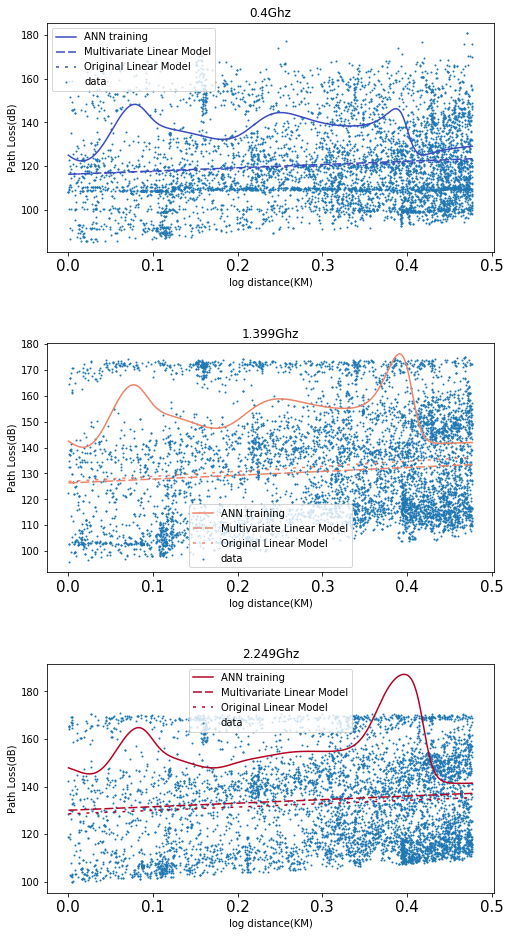

In [15]:
data = makeXforGraphWithGroupingFrequency(pd.DataFrame(X, columns=xCols),
                     pd.DataFrame(Y, columns=['pathloss']), ['logExtendedHeightTratio', 'season'])

graphX = data[0]
graphY = data[1]
train_2d_graph(bestANNModel, bestLinearModel, True, graphX, graphY, 'logDistance', "log distance(KM)")

logDistance                 0.30
logFrequency                0.26
logExtendedHeightTratio     0.28
season                      0.51
pathloss                  120.14
dtype: float64
logDistance                 0.30
logFrequency                0.31
logExtendedHeightTratio     0.27
season                      0.52
pathloss                  132.85
dtype: float64
logDistance                 0.31
logFrequency                0.34
logExtendedHeightTratio     0.27
season                      0.53
pathloss                  132.93
dtype: float64


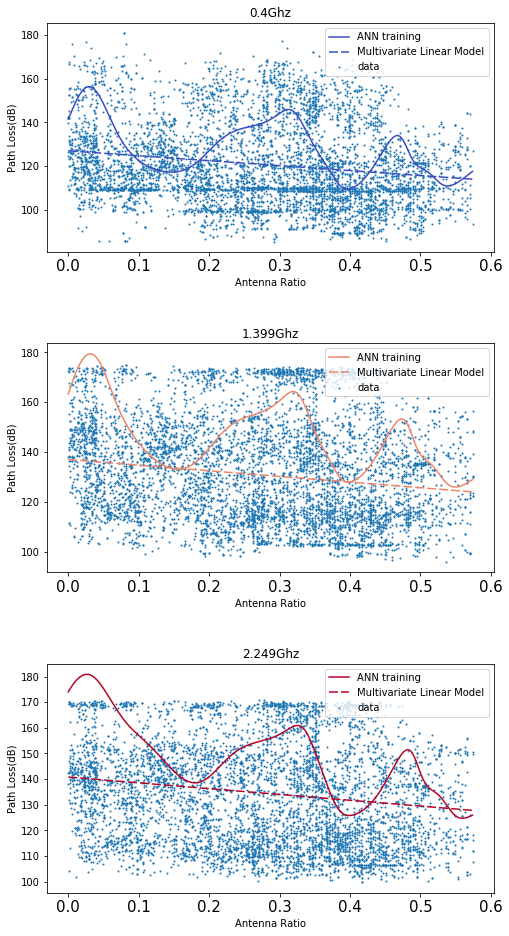

In [16]:
%autoreload
data = makeXforGraphWithGroupingFrequency(pd.DataFrame(X, columns=xCols),
                     pd.DataFrame(Y, columns=['pathloss']), ['logDistance', 'season'])

graphX = data[0]
graphY = data[1]
train_2d_graph(bestANNModel, bestLinearModel, None, graphX, graphY, 'logExtendedHeightTratio', "Antenna Ratio")

logDistance                 0.30
logFrequency                0.26
logExtendedHeightTratio     0.28
season                      0.51
pathloss                  120.14
dtype: float64
logDistance                 0.30
logFrequency                0.31
logExtendedHeightTratio     0.27
season                      0.52
pathloss                  132.85
dtype: float64
logDistance                 0.31
logFrequency                0.34
logExtendedHeightTratio     0.27
season                      0.53
pathloss                  132.93
dtype: float64


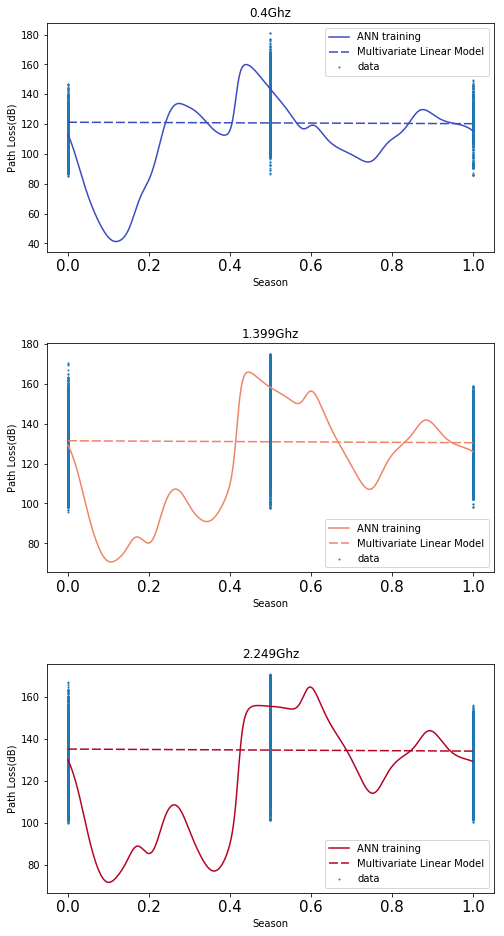

In [17]:
%autoreload
data = makeXforGraphWithGroupingFrequency(pd.DataFrame(X, columns=xCols),
                     pd.DataFrame(Y, columns=['pathloss']), ['logDistance', 'logExtendedHeightTratio'])

graphX = data[0]
graphY = data[1]
train_2d_graph(bestANNModel, bestLinearModel, None, graphX, graphY, 'season', "Season")

3D graph for log distance and log frequency - trainset #1
logDistance                 0.30
logFrequency                0.30
logExtendedHeightTratio     0.27
season                      0.52
pathloss                  128.69
dtype: float64
Index(['logDistance', 'logFrequency', 'logExtendedHeightTratio', 'season'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logExtendedHeightTratio   season
count     10000.00      10000.00                 10000.00 10000.00
mean          0.24          0.30                     0.27     0.52
std           0.14          0.02                     0.00     0.00
min           0.00          0.26                     0.27     0.52
25%           0.12          0.28                     0.27     0.52
50%           0.24          0.30                     0.27     0.52
75%           0.36          0.32                     0.27     0.52
max           0.48          0.34                     0.27     0.52


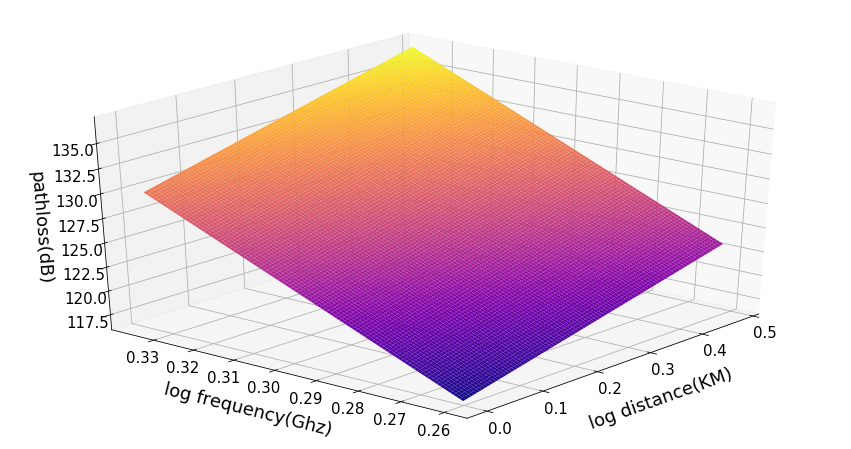

In [18]:
%autoreload
i = 1
print("3D graph for log distance and log frequency - trainset #{}".format(i))
targetCols = ['logDistance', 'logFrequency']
xLabel,yLabel,zLabel = "log distance(KM)","log frequency(Ghz)","pathloss(dB)"
data = makeXforGraph(pd.DataFrame(X, columns=xCols),
                     pd.DataFrame(Y, columns=['pathloss']), targetCols)

graphX = data[0]
graphY = data[1]
train_3d_graph(bestLinearModel, graphX, graphY, targetCols, xLabel, yLabel, zLabel)

3D graph for log distance and log antenna height B+TB/M+TM ratio - trainset #1
logDistance                 0.30
logFrequency                0.30
logExtendedHeightTratio     0.27
season                      0.52
pathloss                  128.69
dtype: float64
Index(['logDistance', 'logFrequency', 'logExtendedHeightTratio', 'season'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logExtendedHeightTratio   season
count     10000.00      10000.00                 10000.00 10000.00
mean          0.24          0.30                     0.29     0.52
std           0.14          0.00                     0.17     0.00
min           0.00          0.30                     0.00     0.52
25%           0.12          0.30                     0.14     0.52
50%           0.24          0.30                     0.29     0.52
75%           0.36          0.30                     0.43     0.52
max           0.48          0.30                     0.57     0.52


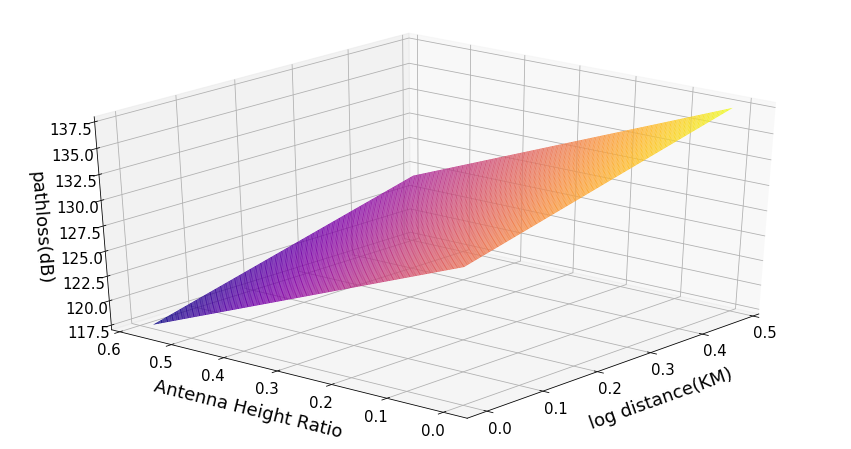

In [19]:
%autoreload
print("3D graph for log distance and log antenna height B+TB/M+TM ratio - trainset #{}".format(i))
xLabel,yLabel,zLabel = "log distance(KM)","Antenna Height Ratio","pathloss(dB)"
varX = ['logDistance', 'logExtendedHeightTratio']
data = makeXforGraph(pd.DataFrame(X, columns=xCols),
                     pd.DataFrame(Y, columns=['pathloss']), varX)

graphX = data[0]
graphY = data[1]
train_3d_graph(bestLinearModel, graphX, graphY, varX, xLabel, yLabel, zLabel)

3D graph for log distance and log antenna height B ratio - trainset #1
logDistance                 0.30
logFrequency                0.30
logExtendedHeightTratio     0.27
season                      0.52
pathloss                  128.69
dtype: float64
Index(['logDistance', 'logFrequency', 'logExtendedHeightTratio', 'season'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logExtendedHeightTratio   season
count     10000.00      10000.00                 10000.00 10000.00
mean          0.24          0.30                     0.27     0.50
std           0.14          0.00                     0.00     0.29
min           0.00          0.30                     0.27     0.00
25%           0.12          0.30                     0.27     0.25
50%           0.24          0.30                     0.27     0.50
75%           0.36          0.30                     0.27     0.75
max           0.48          0.30                     0.27     1.00


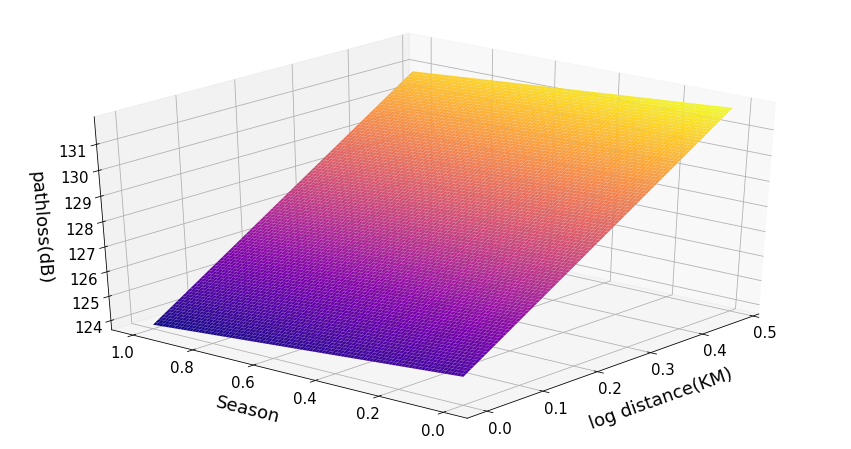

In [20]:
%autoreload
print("3D graph for log distance and log antenna height B ratio - trainset #{}".format(i))
varX = ['logDistance', 'season', ]
xLabel,yLabel,zLabel = "log distance(KM)","Season","pathloss(dB)"
data = makeXforGraph(pd.DataFrame(X, columns=xCols),
                     pd.DataFrame(Y, columns=['pathloss']), varX)

graphX = data[0]
graphY = data[1]
train_3d_graph(bestLinearModel, graphX, graphY, varX, xLabel, yLabel, zLabel)